In [115]:
import pandas as pd
import numpy as np
import datetime as dt
import seaborn as sns
import scipy as sp
import matplotlib.pyplot as plt

from datetime import datetime
from scipy.stats import norm
import math
import re

## wrangle survey

In [116]:
#use pandas to read in the dataset
survey_df = pd.read_csv("surveydata.csv")

#drops
survey_df = survey_df.drop(['Unnamed: 0',
                            'Unnamed: 0.1',
                            'filename',
                            'DataSource'],axis=1)

#For a unique survey, we can make a key variable concatenating  (SubjectID, Year and Date) - KC
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the garmin database -KC
survey_df['relational_key'] = survey_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#For a unique observation in the survey, we can make a key2 with (SubjectID, Year, Date and description) -KC
cols2 = ['SubjectID', 'Year', 'Date','description']
survey_df['unique_table_ID'] = survey_df[cols2].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#key for weather data
survey_df.loc[survey_df['Date'] > 1000, 'Month'] = (survey_df['Date'].astype(str).str[0:2].astype(int))
survey_df.loc[survey_df['Date'] < 1000, 'Month'] = (survey_df['Date'].astype(str).str[0].astype(int))
survey_df['Day'] = round((survey_df['Date'].astype(str).str[-2:].astype(int)),0)

#create datetime column
survey_df['date_time'] = pd.to_datetime(dict(year=survey_df.Year, month=survey_df.Month, day=survey_df.Day))

survey_df = survey_df.drop_duplicates()
survey_df

,description,name,numerical_ans,textual_ans,SubjectID,Year,Date,relational_key,unique_table_ID,Month,Day,date_time
0,Numeric answer for number of hours of sleep fo...,MT Run Follow Up - Previous Nights Sleep (hours),NaN,7.5,58,2018,811,58_2018_811,58_2018_811_Numeric answer for number of hours...,8.0,11,2018-08-11
1,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:03:00 AM,58,2018,811,58_2018_811,58_2018_811_Approximate time of day when run w...,8.0,11,2018-08-11
2,"Type of surface (soft, hard, etc) for route th...",MT Run Follow Up - Surface,NaN,"Hard (sidewalk, asphalt)",58,2018,811,58_2018_811,"58_2018_811_Type of surface (soft, hard, etc) ...",8.0,11,2018-08-11
3,General descriptions of running surface condit...,MT Run Follow Up - Surface Conditions,NaN,Dry,58,2018,811,58_2018_811,58_2018_811_General descriptions of running su...,8.0,11,2018-08-11
4,RPE scale 1-10 of workout difficulty,MT Run Follow Up - How Was Your Workout,NaN,3 - Moderate,58,2018,811,58_2018_811,58_2018_811_RPE scale 1-10 of workout difficulty,8.0,11,2018-08-11
...,...,...,...,...,...,...,...,...,...,...,...,...
5535,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,7:32:00 AM,1998,2017,831,1998_2017_831,1998_2017_831_Approximate time of day when run...,8.0,31,2017-08-31
5536,Numeric answer for number of hours of sleep fo...,MT Run Follow Up - Previous Nights Sleep (hours),NaN,6.00,1998,2017,927,1998_2017_927,1998_2017_927_Numeric answer for number of hou...,9.0,27,2017-09-27
5537,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,7:00:00 AM,1998,2017,927,1998_2017_927,1998_2017_927_Approximate time of day when run...,9.0,27,2017-09-27
5538,"Type of surface (soft, hard, etc) for route th...",MT Run Follow Up - Surface,NaN,"Hard (sidewalk, asphalt)",1998,2017,927,1998_2017_927,"1998_2017_927_Type of surface (soft, hard, etc...",9.0,27,2017-09-27


In [117]:
for col in survey_df.columns:
    pct_missing = np.mean(survey_df[col].isnull())
    print('{} - {}%'.format(col, round(pct_missing*100)))

description - 0%
name - 0%
numerical_ans - 98%
textual_ans - 2%
SubjectID - 0%
Year - 0%
Date - 0%
relational_key - 0%
unique_table_ID - 0%
Month - 0%
Day - 0%
date_time - 0%


## RPE scale 1-10 of workout difficulty table

In [118]:
surveydf_RPEscale = survey_df[survey_df.description ==  'RPE scale 1-10 of workout difficulty']
surveydf_RPEscale['cleaned_column'] = surveydf_RPEscale['textual_ans'].apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])
surveydf_RPEscale['numerical_RPE_scale'] = surveydf_RPEscale.numerical_ans.combine_first(surveydf_RPEscale.cleaned_column)

surveydf_RPEscale = surveydf_RPEscale.drop(['cleaned_column',
                                            'textual_ans',
                                            'numerical_ans',
                                            'name',
                                            'Month',
                                            'Day'],axis=1)

surveydf_RPEscale

<ipython-input-118-10e053deb599>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf_RPEscale['cleaned_column'] = surveydf_RPEscale['textual_ans'].apply(lambda x: [int(s) for s in x.split() if s.isdigit()][0])
<ipython-input-118-10e053deb599>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  surveydf_RPEscale['numerical_RPE_scale'] = surveydf_RPEscale.numerical_ans.combine_first(surveydf_RPEscale.cleaned_column)


,description,SubjectID,Year,Date,relational_key,unique_table_ID,date_time,numerical_RPE_scale
4,RPE scale 1-10 of workout difficulty,58,2018,811,58_2018_811,58_2018_811_RPE scale 1-10 of workout difficulty,2018-08-11,3.0
9,RPE scale 1-10 of workout difficulty,58,2018,609,58_2018_609,58_2018_609_RPE scale 1-10 of workout difficulty,2018-06-09,4.0
14,RPE scale 1-10 of workout difficulty,58,2018,526,58_2018_526,58_2018_526_RPE scale 1-10 of workout difficulty,2018-05-26,3.0
29,RPE scale 1-10 of workout difficulty,58,2018,704,58_2018_704,58_2018_704_RPE scale 1-10 of workout difficulty,2018-07-04,4.0
35,RPE scale 1-10 of workout difficulty,58,2018,818,58_2018_818,58_2018_818_RPE scale 1-10 of workout difficulty,2018-08-18,3.0
...,...,...,...,...,...,...,...,...
5264,RPE scale 1-10 of workout difficulty,2067,2018,825,2067_2018_825,2067_2018_825_RPE scale 1-10 of workout diffic...,2018-08-25,4.0
5269,RPE scale 1-10 of workout difficulty,2067,2018,512,2067_2018_512,2067_2018_512_RPE scale 1-10 of workout diffic...,2018-05-12,7.0
5274,RPE scale 1-10 of workout difficulty,2067,2018,507,2067_2018_507,2067_2018_507_RPE scale 1-10 of workout diffic...,2018-05-07,1.0
5279,RPE scale 1-10 of workout difficulty,2067,2018,508,2067_2018_508,2067_2018_508_RPE scale 1-10 of workout diffic...,2018-05-08,3.0


In [119]:
surveydf_RPEscale.dtypes

description                    object
SubjectID                       int64
Year                            int64
Date                            int64
relational_key                 object
unique_table_ID                object
date_time              datetime64[ns]
numerical_RPE_scale           float64
dtype: object

In [120]:
surveydf_RPEscale['numerical_RPE_scale'].isnull().values.any()

False

## number of hours of sleep for participant on night before the run table

In [121]:
survey_sleep = survey_df[survey_df.description ==  'Numeric answer for number of hours of sleep for participant on night before the run']

survey_sleep['cleaned_column0'] = survey_sleep['textual_ans'].apply(lambda x: re.sub('[a-zA-Z/(/)!,]','',str(x)))
survey_sleep['cleaned_column0b'] = survey_sleep['cleaned_column0'].apply(lambda x: re.sub('[:;-]',' ',str(x)))
survey_sleep['cleaned_column1'] = survey_sleep['cleaned_column0b'].apply(lambda x: [float(num) for num in x.split(' ') if re.match('[0-9]',num)])
survey_sleep['cleaned_column1a'] = survey_sleep['cleaned_column1'].apply(lambda x: ' | '.join(str(y) for y in x))
survey_sleep['cleaned_column1b'] = survey_sleep['cleaned_column1'].apply(lambda x: [np.nan] if len(x)==0 else x)
survey_sleep['sleep_hours'] = survey_sleep['cleaned_column1b'].apply(lambda x: x[0]+x[1]/60 if len(x)>1 else x[0])

survey_sleep.loc[survey_sleep['sleep_hours'].isnull(),'sleep_hours'] = survey_sleep['numerical_ans'] #added MM 

survey_sleep = survey_sleep[['description', 'SubjectID', 'Year', 'Date', 'relational_key','unique_table_ID','sleep_hours','date_time']]

survey_sleep

<ipython-input-121-cf3eaa0a0b74>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_sleep['cleaned_column0'] = survey_sleep['textual_ans'].apply(lambda x: re.sub('[a-zA-Z/(/)!,]','',str(x)))
<ipython-input-121-cf3eaa0a0b74>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  survey_sleep['cleaned_column0b'] = survey_sleep['cleaned_column0'].apply(lambda x: re.sub('[:;-]',' ',str(x)))
<ipython-input-121-cf3eaa0a0b74>:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

,description,SubjectID,Year,Date,relational_key,unique_table_ID,sleep_hours,date_time
0,Numeric answer for number of hours of sleep fo...,58,2018,811,58_2018_811,58_2018_811_Numeric answer for number of hours...,7.500000,2018-08-11
5,Numeric answer for number of hours of sleep fo...,58,2018,609,58_2018_609,58_2018_609_Numeric answer for number of hours...,8.000000,2018-06-09
10,Numeric answer for number of hours of sleep fo...,58,2018,526,58_2018_526,58_2018_526_Numeric answer for number of hours...,7.500000,2018-05-26
16,Numeric answer for number of hours of sleep fo...,58,2017,722,58_2017_722,58_2017_722_Numeric answer for number of hours...,7.500000,2017-07-22
25,Numeric answer for number of hours of sleep fo...,58,2018,704,58_2018_704,58_2018_704_Numeric answer for number of hours...,6.500000,2018-07-04
...,...,...,...,...,...,...,...,...
5519,Numeric answer for number of hours of sleep fo...,1998,2017,621,1998_2017_621,1998_2017_621_Numeric answer for number of hou...,0.173611,2017-06-21
5523,Numeric answer for number of hours of sleep fo...,1998,2017,722,1998_2017_722,1998_2017_722_Numeric answer for number of hou...,5.330000,2017-07-22
5527,Numeric answer for number of hours of sleep fo...,1998,2017,1002,1998_2017_1002,1998_2017_1002_Numeric answer for number of ho...,5.000000,2017-10-02
5531,Numeric answer for number of hours of sleep fo...,1998,2017,824,1998_2017_824,1998_2017_824_Numeric answer for number of hou...,5.000000,2017-08-24


In [122]:
survey_sleep["sleep_hours"].dtypes


dtype('float64')

In [123]:
survey_sleep['sleep_hours'].isnull().values.any()

True

## Type of surface (soft, hard, etc) for route that participant ran

In [124]:
survey_surface = survey_df[survey_df.description ==  'Type of surface (soft, hard, etc) for route that participant ran']
survey_surface = survey_surface.drop(['name',
                                      'numerical_ans',
                                      'Month',
                                      'Day'],axis=1)

survey_surface = survey_surface.rename(columns={"textual_ans": "surface_type"})
survey_surface


,description,surface_type,SubjectID,Year,Date,relational_key,unique_table_ID,date_time
2,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",58,2018,811,58_2018_811,"58_2018_811_Type of surface (soft, hard, etc) ...",2018-08-11
7,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",58,2018,609,58_2018_609,"58_2018_609_Type of surface (soft, hard, etc) ...",2018-06-09
12,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",58,2018,526,58_2018_526,"58_2018_526_Type of surface (soft, hard, etc) ...",2018-05-26
18,"Type of surface (soft, hard, etc) for route th...","Soft (grass, trail)",58,2017,722,58_2017_722,"58_2017_722_Type of surface (soft, hard, etc) ...",2017-07-22
27,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",58,2018,704,58_2018_704,"58_2018_704_Type of surface (soft, hard, etc) ...",2018-07-04
...,...,...,...,...,...,...,...,...
5521,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",1998,2017,621,1998_2017_621,"1998_2017_621_Type of surface (soft, hard, etc...",2017-06-21
5525,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",1998,2017,722,1998_2017_722,"1998_2017_722_Type of surface (soft, hard, etc...",2017-07-22
5529,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",1998,2017,1002,1998_2017_1002,"1998_2017_1002_Type of surface (soft, hard, et...",2017-10-02
5533,"Type of surface (soft, hard, etc) for route th...","Hard (sidewalk, asphalt)",1998,2017,824,1998_2017_824,"1998_2017_824_Type of surface (soft, hard, etc...",2017-08-24


In [125]:
survey_surface.dtypes

description                object
surface_type               object
SubjectID                   int64
Year                        int64
Date                        int64
relational_key             object
unique_table_ID            object
date_time          datetime64[ns]
dtype: object

In [126]:
survey_surface['surface_type'].isnull().values.any()

False

## General descriptions of running surface conditions (dry, wet, icy, etc)

In [127]:
survey_surface_desc = survey_df[survey_df.description ==  'General descriptions of running surface conditions (dry, wet, icy, etc)']
survey_surface_desc = survey_surface_desc.drop(['name','numerical_ans','Month','Day'],axis=1)

survey_surface_desc

,description,textual_ans,SubjectID,Year,Date,relational_key,unique_table_ID,date_time
3,General descriptions of running surface condit...,Dry,58,2018,811,58_2018_811,58_2018_811_General descriptions of running su...,2018-08-11
8,General descriptions of running surface condit...,Dry,58,2018,609,58_2018_609,58_2018_609_General descriptions of running su...,2018-06-09
13,General descriptions of running surface condit...,Dry,58,2018,526,58_2018_526,58_2018_526_General descriptions of running su...,2018-05-26
19,General descriptions of running surface condit...,Dry,58,2017,722,58_2017_722,58_2017_722_General descriptions of running su...,2017-07-22
28,General descriptions of running surface condit...,Dry,58,2018,704,58_2018_704,58_2018_704_General descriptions of running su...,2018-07-04
...,...,...,...,...,...,...,...,...
5522,General descriptions of running surface condit...,Dry,1998,2017,621,1998_2017_621,1998_2017_621_General descriptions of running ...,2017-06-21
5526,General descriptions of running surface condit...,Dry,1998,2017,722,1998_2017_722,1998_2017_722_General descriptions of running ...,2017-07-22
5530,General descriptions of running surface condit...,"Snow, Ice",1998,2017,1002,1998_2017_1002,1998_2017_1002_General descriptions of running...,2017-10-02
5534,General descriptions of running surface condit...,Dry,1998,2017,824,1998_2017_824,1998_2017_824_General descriptions of running ...,2017-08-24


In [128]:
survey_surface_desc.dtypes

description                object
textual_ans                object
SubjectID                   int64
Year                        int64
Date                        int64
relational_key             object
unique_table_ID            object
date_time          datetime64[ns]
dtype: object

In [129]:
survey_surface_desc['textual_ans'].isnull().values.any()

False

## Approximate time of day when run was performed

In [130]:
survey_tod = survey_df[survey_df.description ==  'Approximate time of day when run was performed']
survey_tod

,description,name,numerical_ans,textual_ans,SubjectID,Year,Date,relational_key,unique_table_ID,Month,Day,date_time
1,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:03:00 AM,58,2018,811,58_2018_811,58_2018_811_Approximate time of day when run w...,8.0,11,2018-08-11
6,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:02:00 AM,58,2018,609,58_2018_609,58_2018_609_Approximate time of day when run w...,6.0,9,2018-06-09
11,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:05:00 AM,58,2018,526,58_2018_526,58_2018_526_Approximate time of day when run w...,5.0,26,2018-05-26
15,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:01:00 AM,58,2018,915,58_2018_915,58_2018_915_Approximate time of day when run w...,9.0,15,2018-09-15
17,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:05:00 AM,58,2017,722,58_2017_722,58_2017_722_Approximate time of day when run w...,7.0,22,2017-07-22
...,...,...,...,...,...,...,...,...,...,...,...,...
5524,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,8:06:00 AM,1998,2017,722,1998_2017_722,1998_2017_722_Approximate time of day when run...,7.0,22,2017-07-22
5528,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,7:17:00 AM,1998,2017,1002,1998_2017_1002,1998_2017_1002_Approximate time of day when ru...,10.0,2,2017-10-02
5532,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,7:24:00 AM,1998,2017,824,1998_2017_824,1998_2017_824_Approximate time of day when run...,8.0,24,2017-08-24
5535,Approximate time of day when run was performed,MT Run Follow Up - Time of Run,NaN,7:32:00 AM,1998,2017,831,1998_2017_831,1998_2017_831_Approximate time of day when run...,8.0,31,2017-08-31


In [131]:
survey_tod.dtypes

description                object
name                       object
numerical_ans             float64
textual_ans                object
SubjectID                   int64
Year                        int64
Date                        int64
relational_key             object
unique_table_ID            object
Month                     float64
Day                         int32
date_time          datetime64[ns]
dtype: object

## wrangle garmin

In [140]:
garmin_df = pd.read_csv("garmindata.csv")

#For a unique survey, we can make a key variable concatenating  (SubjectID, Year and Date) - KC
cols = ['SubjectID', 'Year', 'Date'] #This key variable might help to find same observation in the garmin database -KC
garmin_df['relational_key'] = garmin_df[cols].apply(lambda row: '_'.join(row.values.astype(str)), axis=1)

#create dt column
garmin_df.loc[garmin_df['Date'] > 1000, 'Month'] = (garmin_df['Date'].astype(str).str[0:2].astype(int))
garmin_df.loc[garmin_df['Date'] < 1000, 'Month'] = (garmin_df['Date'].astype(str).str[0].astype(int))
garmin_df['Day'] = round((garmin_df['Date'].astype(str).str[-2:].astype(int)),0)

garmin_df['date_time'] = pd.to_datetime(dict(year=garmin_df.Year, month=garmin_df.Month, day=garmin_df.Day))

In [141]:
#bin the garmin datatable
garmin_df = garmin_df[garmin_df["SubjectID"] != 2069] #in a car?
garmin_df = garmin_df[garmin_df["SubjectID"] != 2067] #duplicate with 2052
garmin_df = garmin_df[garmin_df["record.distance[m]"] > 0] #distance of 0

#inner join
garmin_sleep_df = pd.merge(garmin_df, survey_sleep, how="inner", on=["relational_key"])

garmin_sleep_df = garmin_sleep_df.drop(['Unnamed: 0',
                                       'Unnamed: 0.1',
                                       'filename',
                                       'record.position_lat[semicircles]',
                                       'record.position_long[semicircles]',
                                       'description',
                                       'DataSource',
                                       'date_time_x',
                                       'SubjectID_x',
                                       'Year_x',
                                       'Date_x'],axis=1)

garmin_sleep_df

,record.altitude[m],record.distance[m],record.heart_rate[bpm],record.speed[m/s],record.timestamp[s],relational_key,Month,Day,SubjectID_y,Year_y,Date_y,unique_table_ID,sleep_hours,date_time_y,binned_sleep
0,1003.4,1.72,97.0,1.642,0.0,58_2017_729,7.0,29,58,2017,729,58_2017_729_Numeric answer for number of hours...,7.5,2017-07-29,"(7, 8]"
1,1003.4,3.42,97.0,1.642,1.0,58_2017_729,7.0,29,58,2017,729,58_2017_729_Numeric answer for number of hours...,7.5,2017-07-29,"(7, 8]"
2,1003.4,20.37,98.0,2.566,8.0,58_2017_729,7.0,29,58,2017,729,58_2017_729_Numeric answer for number of hours...,7.5,2017-07-29,"(7, 8]"
3,1003.6,41.56,100.0,2.650,16.0,58_2017_729,7.0,29,58,2017,729,58_2017_729_Numeric answer for number of hours...,7.5,2017-07-29,"(7, 8]"
4,1003.4,61.90,101.0,2.613,24.0,58_2017_729,7.0,29,58,2017,729,58_2017_729_Numeric answer for number of hours...,7.5,2017-07-29,"(7, 8]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4052418,29.4,21245.12,175.0,2.211,9126.0,1998_2017_1008,10.0,8,1998,2017,1008,1998_2017_1008_Numeric answer for number of ho...,5.0,2017-10-08,"(4, 5]"
4052419,29.4,21247.32,175.0,2.221,9127.0,1998_2017_1008,10.0,8,1998,2017,1008,1998_2017_1008_Numeric answer for number of ho...,5.0,2017-10-08,"(4, 5]"
4052420,29.4,21249.16,175.0,2.230,9128.0,1998_2017_1008,10.0,8,1998,2017,1008,1998_2017_1008_Numeric answer for number of ho...,5.0,2017-10-08,"(4, 5]"
4052421,29.4,21250.59,175.0,2.221,9129.0,1998_2017_1008,10.0,8,1998,2017,1008,1998_2017_1008_Numeric answer for number of ho...,5.0,2017-10-08,"(4, 5]"


In [161]:
avg_hr = garmin_sleep_df[['relational_key','record.heart_rate[bpm]']]
avg_hr = avg_hr.groupby('relational_key').mean()

distances = garmin_sleep_df[['relational_key','record.distance[m]']]
distances = distances.groupby('relational_key').max()

sleep_hours = garmin_sleep_df[['relational_key','sleep_hours']]
sleep_hours = sleep_hours.groupby('relational_key').mean()

m1 = pd.merge(avg_hr, distances, how="inner", on=["relational_key"])
m1.reset_index(inplace=True)
m2 = pd.merge(m1, sleep_hours, how="inner", on=["relational_key"])


#0 to 50th percentile to 10km(arbitrary)
bins = [0,5137.28,25000]
m2["binned_dist"] = pd.cut(m2['record.distance[m]'], bins)

#bin the sleep survey datatable
bins = [0,5,8,18]
m2["binned_sleep"] = pd.cut(m2['sleep_hours'], bins)

#some avg heart rates are very low or very high, 50 is bottom cutpoint and 200 is top cutpoint 
m2 = m2[(m2['record.heart_rate[bpm]']<250) & (m2['record.heart_rate[bpm]']>50)]
m2.head()

,relational_key,record.heart_rate[bpm],record.distance[m],sleep_hours,binned_dist,binned_sleep
0,1942_2017_1008,153.876819,42596.89,7.5,NaN,"(5, 8]"
1,1942_2017_621,153.558452,7216.20,7.0,"(5137.28, 25000.0]","(5, 8]"
2,1942_2017_624,148.400662,10116.38,7.0,"(5137.28, 25000.0]","(5, 8]"
3,1942_2017_706,157.845395,12821.34,7.0,"(5137.28, 25000.0]","(5, 8]"
4,1942_2017_708,161.777100,18838.17,7.0,"(5137.28, 25000.0]","(5, 8]"


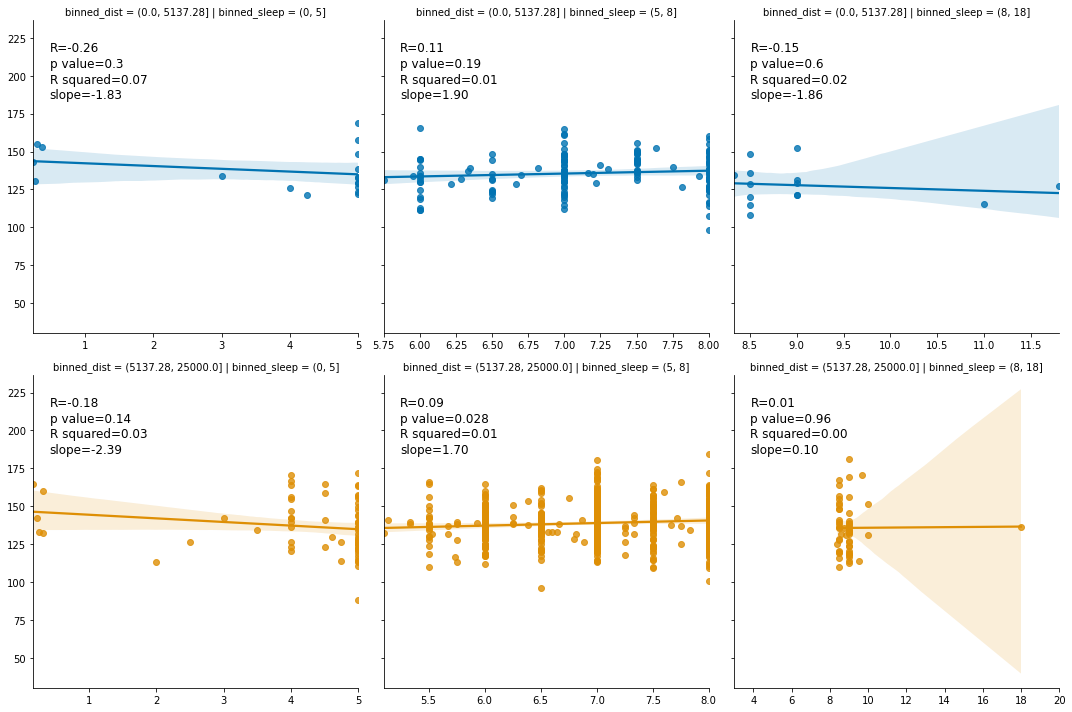

In [159]:
#df = df.rename(columns={"age": "Age (years)", "fev": "FEV1 (Liters)"})

g = sns.lmplot(x='sleep_hours', y='record.heart_rate[bpm]', data=m2, col='binned_sleep', row="binned_dist", hue="binned_dist", palette='colorblind', sharex=False)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['sleep_hours'], data['record.heart_rate[bpm]'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['sleep_hours'],data['record.heart_rate[bpm]'])
    ax = plt.gca()
    ax.text(.05, .9, 'R={:.2f}'.format(r, p), size=12,
            transform=ax.transAxes)
    ax.text(.05, .85, 'p value={:.2g}'.format(p), size=12,
            transform=ax.transAxes)
    ax.text(.05, .8, 'R squared={:.2f}'.format((r_value*r_value)), size=12,
            transform=ax.transAxes)
    ax.text(.05, .75, 'slope={:.2f}'.format(slope), size=12,
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.xlim(3, 20)
plt.show()

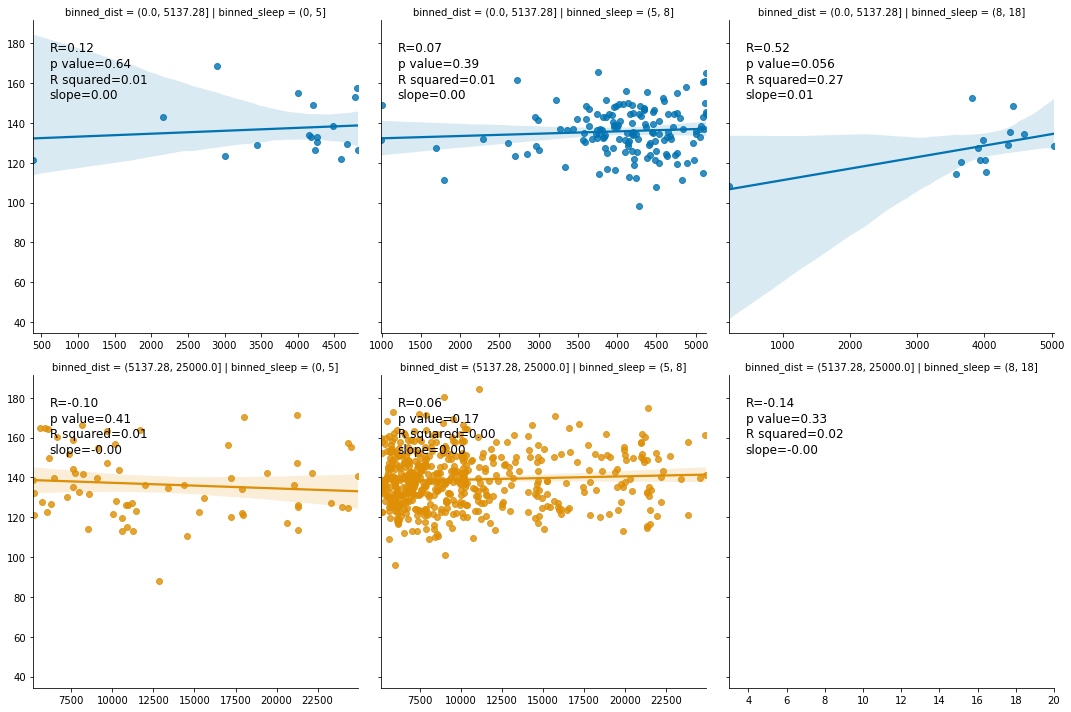

In [160]:
#df = df.rename(columns={"age": "Age (years)", "fev": "FEV1 (Liters)"})

g = sns.lmplot(x='record.distance[m]', y='record.heart_rate[bpm]', data=m2, col='binned_sleep', row="binned_dist", hue="binned_dist", palette='colorblind', sharex=False)

def annotate(data, **kws):
    r, p = sp.stats.pearsonr(data['record.distance[m]'], data['record.heart_rate[bpm]'])
    slope, intercept, r_value, p_value, std_err = sp.stats.linregress(data['record.distance[m]'],data['record.heart_rate[bpm]'])
    ax = plt.gca()
    ax.text(.05, .9, 'R={:.2f}'.format(r, p), size=12,
            transform=ax.transAxes)
    ax.text(.05, .85, 'p value={:.2g}'.format(p), size=12,
            transform=ax.transAxes)
    ax.text(.05, .8, 'R squared={:.2f}'.format((r_value*r_value)), size=12,
            transform=ax.transAxes)
    ax.text(.05, .75, 'slope={:.2f}'.format(slope), size=12,
            transform=ax.transAxes)
    
g.map_dataframe(annotate)
plt.xlim(3, 20)
plt.show()